# Rate based implementation of a line-attractor

We implement this as ring-attractor to avoid the complication of boundary conditions, that is dealing with the edges of the network. This simplification does not affect the conclusions of the current study. Whether the neurla implementation in the animal is a ring or line attractor will affect what will happen if we force the animal to exceed its maximum distance that can be represented by the network. Such an experiment is in the plan but not done yet. 

This model is based on the Dunamic Neural Field model of Fundamentals of Computational Neuroscience, Thomas Trappenberg, pp 194

In [78]:
# Import libraries
import numpy as np
# for numerical ODE integration
from scipy import integrate
# for plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

# Diplay options:
# to display plots in-line
%matplotlib inline
plt.style.use('ggplot')

# to display plots in separate windows (interactive)
#%matplotlib qt 


In [79]:
nn = 100              # 100 neurons
dx = 2 * np.pi / nn   # Spatial resolution
sig = 2 * np.pi / 10
C = 0.5               # Inhibition strength

In [80]:
def logistic(x, slope=1, bias=0):
    """ Logistic function of x with specified slope and bias.
        slope : slope of the sigmoid
        bias  : bias of the sigmoid """
    return 1 / (1 + np.exp(-slope * (x - bias)))

def sigmoid(x):
    """ Sigmoid of x is a special case of the logistic function """
    return logistic(x, slope=1, bias=0)


def vonmises(x, mu=180*np.pi/180, kappa=1):
    """ Returns the values of a von Mises (circular Gaussian) with 
        centre at mu and width kappa at the sample points in x. 
        x : a vector with the sample points 0:2*pi
        mu : the von mises distribution center [0:2*pi]
        kappa : specifies the width of the Gaussian
        Returns a vector with the values from the distribution. 
        Example: 
            mu=180*pi/180; kappa=0.5; i=[0:100]; x = 2 * pi * i / 100
            v = vonmises(x, mu, kappa) """
    if (kappa > 5):
        return np.exp(kappa * (np.cos(x - mu) - 1))
    return (np.exp(kappa * (np.cos(x - mu) + 1)) - 1) / (np.exp(2 * kappa) - 1);

def wrapN(x, n):
    """ Helper function converting index into the range 0:n-1 """
    return np.mod(x, n)

def population_vector(input_vec, pref_direction_vec):
    """ Population vector direction decoding. It is not perfect but good enough.
        input_vec          : vector of neuron activities
        pref_direction_vec : preferred directions of neurons
        Returns the direction encoded by the population code.
        The calculation used is based on https://en.wikipedia.org/wiki/Population_vector """
    #  Get the first max position
    max_pos = np.argmax(input_vec)
    vec = pref_direction_vec[max_pos] # Get prefered direction of the max
    
    # If we have adequate distance from the edges consider +-sample_frac samples 
    # around the max position for improved accuracy
    sample_frac = 0.1
    if (max_pos >= np.size(input_vec) * sample_frac and max_pos <= np.size(input_vec) * (1-sample_frac)):
        nominator_sum = 0
        denominator_sum = 0
        from_val = (max_pos - np.size(input_vec) * sample_frac + 1).astype(int)
        to_val   = (max_pos + np.size(input_vec) * sample_frac).astype(int)
        for i in range(from_val, to_val):
            item = wrapN(i, np.size(input_vec))
            nominator_sum = nominator_sum + input_vec[item] * pref_direction_vec[item]
            denominator_sum = denominator_sum + input_vec[item]
        vec = nominator_sum / denominator_sum
    
    return vec


In [81]:
class WeightMatrixGenerator(object):
    
    @staticmethod
    def train_weight_matrix(nn, dx, sig, C):
        """ Train weights matrix. Equivalent to global inhibition with 
            gaussian shaped excitation of nearest neighbours.
            nn : Number of neurons
            dx : 
            sig:
            C  : Strength of inhibition
            w  : (Returns) a square nnxnn weight matrix
            Method used by Dynamic Neural Field model of Fundamentals of 
            Computational Neuroscience, Thomas Trappenberg, pp 194. """        
        neuron_id = range(nn)       # Neuron numbering 0:99
        i = np.array([neuron_id]).T # Create a column vector. Use list in list because it has to be 2D to transpose it 
        pat = np.zeros((nn, nn))    # Trainning patterns
        for loc in neuron_id:       # For every neuron in the list
            dis = np.minimum(np.abs(i-loc), nn - np.abs(i-loc)) # Circular distances
            pat[:, loc] = np.exp(-(dx*dis) ** 2 / (2 * sig**2)).reshape((1, -1)) # Reshape to 1D vector before assignment

        # Calculate the weight matrix
        w = np.matmul(pat, pat.T)
        w = w / w[1, 1] # Normalise
        w = 4 * (w - C) # Add inhibition and scale

        return w
    
    @staticmethod
    def cosine_weight_matrix(nn, bias, amplitude):
        """ Generate cosine weights matrix. Strength of synaptes is a 
            function of the cosine of the distance from the current 
            neuron. Synapses to nearest neightbours are excitatory and 
            to furthest neurons inhibitory.
            nn : Number of neurons
            bias : Bias term, must be negative
            amplitude : Amplitude term, must be positive
            w  : (Returns) a square nnxnn weight matrix
            Method used by Dynamic Neural Field model of Fundamentals of 
            Computational Neuroscience, Thomas Trappenberg, pp 194. """        

        neuron_id = range(nn)       # Neuron numbering 0:99
        i = np.array([neuron_id]).T # Create a column vector. Use list in list because it has to be 2D to transpose it 
        pat = np.zeros((nn, nn))    # Synnaptic strengths pattern
        for loc in neuron_id:       # For every neuron in the list
            dis = np.minimum(np.abs(i-loc), nn - np.abs(i-loc)) # Circular distances
            pat[:, loc] = bias + amplitude * np.cos(dis * 2 * np.pi / nn).reshape((1, -1)) # Reshape to 1D vector before assignment
        w = pat
        return w
    

    
    @staticmethod
    def wta_weight_matrix(nn, weight_positive, weight_negative):
        """ Copied from Kim's 2017 code not sure what parameter 
            values are needed for stable bump. 
            weight_positive : the value of the weight to the neuron itself
            weight_negative : the value of the inhibition to all other neurons
            w  : (Returns) a square nnxnn weight matrix with the diagonal 
                 set to weight_positive and all other elements to weight_negative """
        neuron_id = range(nn)       # Neuron numbering 0:99
        i = np.array([neuron_id]).T # Create a column vector. Use list in list because it has to be 2D to transpose it 
        pat = -weight_negative * np.ones((nn, nn))    # Synnaptic strengths pattern
        for loc in neuron_id:       # For every neuron in the list
            pat[loc, loc] = weight_positive
        w = pat
        return w

        
    

In [82]:
# Weight matrix options:

# 1. Training the weight matrix
w = WeightMatrixGenerator.train_weight_matrix(nn, dx, sig, C)

# 2. Cosine of synaptic distance weight matrix
cos_bias = 0      # This can drive all neurons to silence or excitation
cos_amplitude = 2 # 1.3 is the minimum for bump to form. Above 10 the bump becomes square shaped
w = WeightMatrixGenerator.cosine_weight_matrix(nn, cos_bias, cos_amplitude)


In [83]:
def rnn_ode(t, u):
    ''' The right hand side of the differential equation '''
    # ODE solver for recurrent network
    tau = 1           # Membrane time constant
    tau_inv = 1 / tau # Inverse of membrane time constant
    r = sigmoid(u)
    sum1  = np.matmul(w, r) * dx
    udot = tau_inv * (-u + sum1 + I_ext)
    return udot

Text(0.5,0,'Activity')

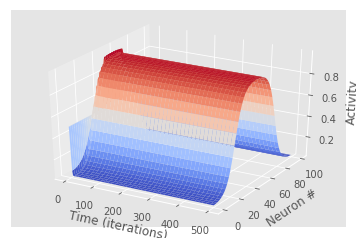

In [84]:
# Arrays to record values into
tall = np.empty((0, 1))
rall = np.empty((0, nn))
pva_all = np.empty((0, 1))


# Update with localised input
# integration period
I_ext = np.zeros(nn)
I_ext[(nn/2-np.floor(nn/10)).astype(int):(nn/2+np.floor(nn/10)).astype(int)] = 1
t_simulation_start = 0
t_simulation_end = 10
t_simulation = (t_simulation_start, t_simulation_end)
init_value = np.zeros(nn)
solution = integrate.solve_ivp(rnn_ode, t_simulation, init_value, 'RK45')
t = solution.t
u = solution.y
# Calculate firing rates
r = sigmoid(u)

# Record data
tall = np.vstack((tall, t.reshape(1, -1).T))
rall = np.vstack((rall, r.T))

# Update without input
I_ext = np.zeros(nn)
t_simulation_start = 10
t_simulation_end = 500
t_simulation = (t_simulation_start, t_simulation_end)
init_value = u[:,-1] # The new initial value is the last state
solution = integrate.solve_ivp(rnn_ode, t_simulation, init_value, 'RK45')
t = solution.t
u = solution.y
# Calculate firing rates
r = sigmoid(u)

# Record data
tall = np.vstack((tall, t.reshape(1, -1).T))
rall = np.vstack((rall, r.T))

# Estimate bump location
pref_direction_vec = np.linspace(0, 2*np.pi, num=100)
for i in xrange(np.shape(rall)[0]):
    pva = population_vector(rall[i, :], pref_direction_vec)
    pva_all = np.vstack((pva_all, pva.reshape(1, -1).T)) 

    
# Plot the results
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(tall, range(nn))
ax.plot_surface(X, Y, rall.T, cmap=cm.coolwarm,
                       linewidth=1, antialiased=True)

ax.set_xlabel('Time (iterations)')
ax.set_ylabel('Neuron #')
ax.set_zlabel('Activity')


(0, 360)

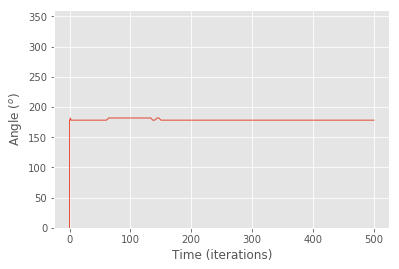

In [88]:
# Plot the results
fig = plt.figure()
ax = fig.add_subplot(111)
X, Y = np.meshgrid(tall, range(nn))
pva_all_in_deg =  180 / np.pi * pva_all
pva_all_in_deg = pva_all_in_deg.reshape((1, -1)).T
ax.plot(tall, pva_all_in_deg, linewidth=1, antialiased=True) # Reshape to 1D vector before assignment

ax.set_xlabel('Time (iterations)')
ax.set_ylabel('Angle ($^o$)')
ax.set_ylim((0,360))




### Cells after that are only for testing the values

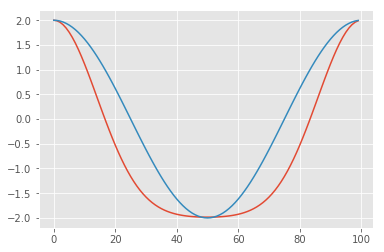

In [9]:
# Plot the results
fig = plt.figure()
ax = fig.add_subplot(111)
w = WeightMatrixGenerator.train_weight_matrix(nn, dx, sig, C)
ax.plot(w[:,0])
w = WeightMatrixGenerator.cosine_weight_matrix(nn, -0.2, 0.15)
w = WeightMatrixGenerator.cosine_weight_matrix(nn, cos_bias, cos_amplitude)
ax.plot(w[:,0])

#w = WeightMatrixGenerator.wta_weight_matrix(nn, weight_positive, weight_negative)
#ax.plot(w[:,0])



/Users/john/Library/Python/2.7/lib/python/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


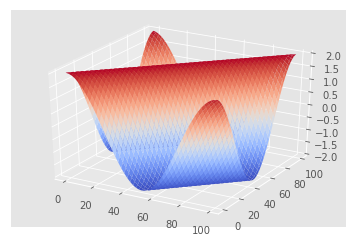

In [10]:
# Plot the results
fig = plt.figure()
ax = fig.add_subplot(111)
w = WeightMatrixGenerator.train_weight_matrix(nn, dx, sig, C)
#w = WeightMatrixGenerator.cosine_weight_matrix(nn, -0.2, 0.15)
w = WeightMatrixGenerator.cosine_weight_matrix(nn, cos_bias, cos_amplitude)
#w = WeightMatrixGenerator.wta_weight_matrix(nn, alpha, beta)


ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(range(nn), range(nn))
ax.plot_surface(X, Y, w, cmap=cm.coolwarm,
                       linewidth=1, antialiased=True)






In [25]:
np.shape(rall)

(165, 100)

In [27]:
rall[1,:]

array([0.5     , 0.5     , 0.5     , 0.5     , 0.5     , 0.5     ,
       0.5     , 0.5     , 0.5     , 0.5     , 0.5     , 0.5     ,
       0.5     , 0.5     , 0.5     , 0.5     , 0.5     , 0.5     ,
       0.5     , 0.5     , 0.5     , 0.5     , 0.5     , 0.5     ,
       0.5     , 0.5     , 0.5     , 0.5     , 0.5     , 0.5     ,
       0.5     , 0.5     , 0.5     , 0.5     , 0.5     , 0.5     ,
       0.5     , 0.5     , 0.5     , 0.5     , 0.500025, 0.500025,
       0.500025, 0.500025, 0.500025, 0.500025, 0.500025, 0.500025,
       0.500025, 0.500025, 0.500025, 0.500025, 0.500025, 0.500025,
       0.500025, 0.500025, 0.500025, 0.500025, 0.500025, 0.500025,
       0.5     , 0.5     , 0.5     , 0.5     , 0.5     , 0.5     ,
       0.5     , 0.5     , 0.5     , 0.5     , 0.5     , 0.5     ,
       0.5     , 0.5     , 0.5     , 0.5     , 0.5     , 0.5     ,
       0.5     , 0.5     , 0.5     , 0.5     , 0.5     , 0.5     ,
       0.5     , 0.5     , 0.5     , 0.5     , 0.5     , 0.5  